In [2]:
import triangle as tr

import numpy as np
from numpy.linalg import norm
from itertools import combinations
from scipy import constants

# Plotting
import scienceplots
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import matplotlib.patches as patches
from cmap import Colormap

plt.style.use(["science"])

In [3]:
# A = dict(vertices=np.array(((-1, -1), (1, -1), (1, 1), (-1, 1))))
# T = tr.triangulate(A, f"DFqa{0.0005}")
# np.savez('square_triangulation.npz', vertices=T["vertices"], triangles=T["triangles"])
tri_data = np.load('Assignment2/data/square_triangulation.npz')

In [4]:
Vs = tri_data['vertices']
Ts = tri_data['triangles']

Xs = Vs[:, 0]
Ys = Vs[:, 1]

triang = mtri.Triangulation(Xs, Ys, Ts)

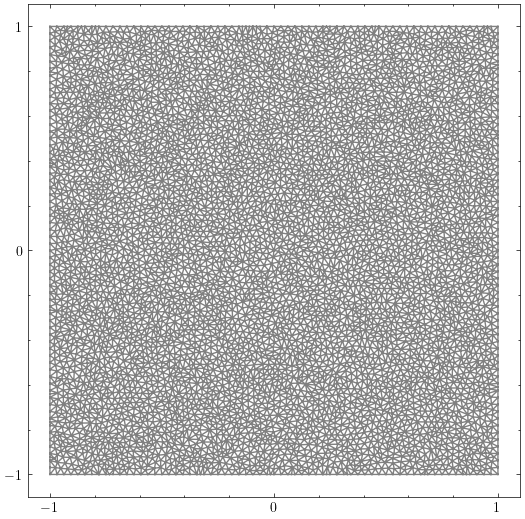

In [13]:
fig, ax = plt.subplots(figsize=(0.8 * 8, 0.8 * 8))
plt.triplot(triang, lw=1, c="grey")
ax.set_yticks([-1, 0, 1])
ax.set_xticks([-1, 0, 1])
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_aspect('equal')
fig.savefig("square_triangulation.pdf", format="pdf")

In [6]:
source1_loc = np.array([0.3, 0.7])
source1_radius = 0.1
source1_strength = 10
source2_loc = np.array([-0.7, 0.3])
source2_radius = 0.1
source2_strength = 3
source3_loc = np.array([-0.3, -0.7])
source3_radius = 0.1
source3_strength = 1
source4_loc = np.array([0.7, -0.3])
source4_radius = 0.1
source4_strength = 3

def f2(x, y):
    input = np.array([x, y])
    s1 = norm(input - np.array([0.3, 0.7]), axis=0) < source1_radius
    s2 = norm(input - np.array([-0.7, 0.3]), axis=0) < source2_radius
    s3 = norm(input - np.array([-0.3, -0.7]), axis=0) < source3_radius
    s4 = norm(input - np.array([0.7, -0.3]), axis=0) < source4_radius
    return 1 * (
        source1_strength * s1 +
        source2_strength * s2 +
        source3_strength * s3 +
        source4_strength * s4)

def fv2(x, y):
    input = np.array([x, y])
    s1 = norm(input-   np.array([0.3, 0.7])[:, None, None], axis=0) < source1_radius
    s2 = norm(input-  np.array([-0.7, 0.3])[:, None, None], axis=0) < source2_radius
    s3 = norm(input- np.array([-0.3, -0.7])[:, None, None], axis=0) < source3_radius
    s4 = norm(input-  np.array([0.7, -0.3])[:, None, None], axis=0) < source4_radius
    return 1 * (
        source1_strength * s1 +
        source2_strength * s2 +
        source3_strength * s3 +
        source4_strength * s4)

In [7]:
cmap2 = Colormap("crameri:batlowk").to_mpl()
cmap = Colormap("colorcet:CET_L17").to_mpl()

(-1.1, 1.1)

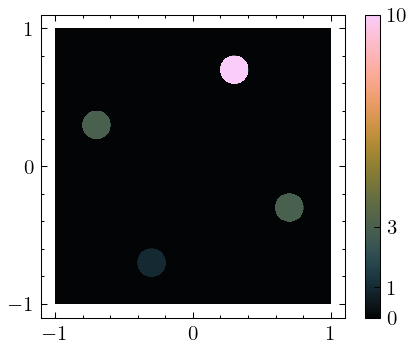

In [8]:
fig, ax = plt.subplots(dpi=150)
ax.set_yticks([-1, 0, 1])
ax.set_xticks([-1, 0, 1])
ax.set_aspect("equal")
xs = np.arange(-1, 1.002, 0.002)
ys = np.arange(-1, 1.002, 0.002)
X, Y = np.meshgrid(xs, ys) # grid of point
Z = fv2(X, Y)

im = ax.contourf(X, Y, Z, cmap=cmap2, levels=256, vmin=0, vmax=10)
cbar = fig.colorbar(im, orientation='vertical')
cbar.set_ticks([0, 1, 3, 10])
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])

In [15]:
data = {}
boundary_indices = [index for index in np.unique(Ts.ravel()) if (
    ((Vs[index] == [0., 1.]).sum() > 0) or
    ((Vs[index] == [1., 0.]).sum() > 0)
)]
edges = {}

# For K in T
size = len(Ts)
A = np.zeros((size, size))
B = np.zeros(size)

triangle_to_id = {}

for k_id, k in enumerate(Ts):
    k_key = str(k)
    
    # Handle edges
    for edge in combinations(k, 2):
        edge = np.sort(edge, axis=0)
        edge_key = str(edge)
        
        if edge_key not in edges:
            edges[edge_key] = {"arr": edge, "vertices": np.array([Vs[index] for index in edge]), "connections": [k]}
        else:
            edges[edge_key]["connections"].append(k)
    
    # Set data dependent only on K
    triangle_to_id[k_key] = k_id
    data[k_id] = {}
    data[k_id]["triangle"] = k
    vertices = np.array([Vs[index] for index in k])
    area = np.abs(0.5 * np.cross(vertices[0] - vertices[1], vertices[0] - vertices[2]))
    data[k_id]["x_k"] = np.mean(vertices, axis=0)
    
    B[k_id] = (np.sum([f2(vertex[0], vertex[1]) for vertex in vertices]) / 3) * area
    k_id += 1

c = 0
for edge_key in edges:
    edge = edges[edge_key]["arr"]
    connections = edges[edge_key]["connections"]
    vertices = edges[edge_key]["vertices"]
    m = norm(vertices[0] - vertices[1]) 
    
    if len(connections) == 1:
        # If on boundary
        
        k = connections[0]
        k_key = str(k)
        k_id = triangle_to_id[k_key]
        d = norm(np.cross(vertices[0] - vertices[1], vertices[1] - data[k_id]["x_k"])) / norm(vertices[0] - vertices[1])  # Perpendicular distance
        t_sigma = m / d
        
        A[k_id, k_id] += t_sigma
        
    else:
        # If internal
        
        k, l = connections
        k_id = triangle_to_id[str(k)]
        l_id = triangle_to_id[str(l)]
        d = np.linalg.norm(data[k_id]["x_k"] - data[l_id]["x_k"])
        t_sigma = m / d
        
        A[k_id, l_id] -= t_sigma
        A[k_id, k_id] += t_sigma
        
        A[l_id, k_id] -= t_sigma
        A[l_id, l_id] += t_sigma
        
U2 = np.linalg.solve(A, B)

In [10]:
# x_k_arrays = np.array([entry["x_k"] for entry in data.values()])
# print(x_k_arrays.shape)
# np.save("square_testdata", x_k_arrays)

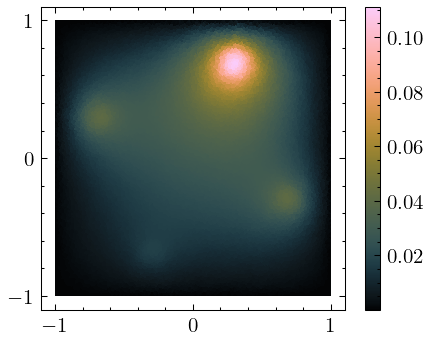

In [11]:
fig, ax = plt.subplots(dpi=150)
ax.set_yticks([-1, 0, 1])
ax.set_xticks([-1, 0, 1])
ax.set_aspect("equal")
im = ax.tripcolor(triang, U2, cmap=cmap2)
cbar = fig.colorbar(im, orientation='vertical')

plt.show()

In [12]:
arr1 = np.load("./Assignment2/data/square_epoch20000_0.02.npy")
fig, ax = plt.subplots(dpi=150)
ax.set_yticks([-1, 0, 1])
ax.set_xticks([-1, 0, 1])
ax.set_aspect("equal")

Uarr1 = arr1.reshape(-1)
print(len(Uarr1))

im = ax.tripcolor(triang, Uarr1, cmap=cmap2)
cbar = fig.colorbar(im, orientation='vertical')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './Assignment2/data/square_epoch20000_0.02.npy'

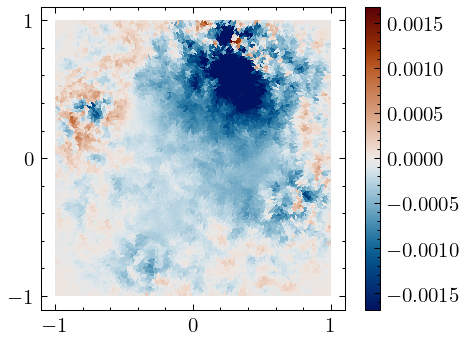

In [15]:
fig, ax = plt.subplots(dpi=150)
ax.set_yticks([-1, 0, 1])
ax.set_xticks([-1, 0, 1])
ax.set_aspect("equal")

diff = U2 - Uarr1
m = np.max(diff)

cmap_diff = Colormap("crameri:vik").to_mpl()

im = ax.tripcolor(triang, diff, cmap=cmap_diff, vmin=-m, vmax=m)
cbar = fig.colorbar(im, orientation='vertical')
plt.show()

12442


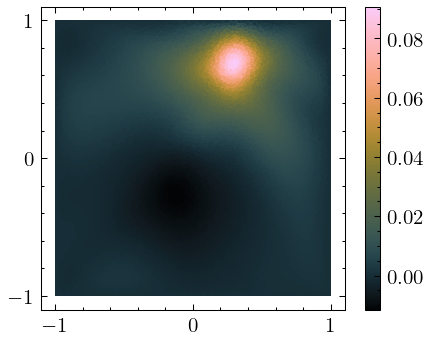

In [17]:
arr2 = np.load("./Assignment2/data/1_square_epoch20000_0.04.npy")
fig, ax = plt.subplots(dpi=150)
ax.set_yticks([-1, 0, 1])
ax.set_xticks([-1, 0, 1])
ax.set_aspect("equal")

Uarr2 = arr2.reshape(-1)
print(len(Uarr2))

im = ax.tripcolor(triang, Uarr2, cmap=cmap2)
cbar = fig.colorbar(im, orientation='vertical')
plt.show()

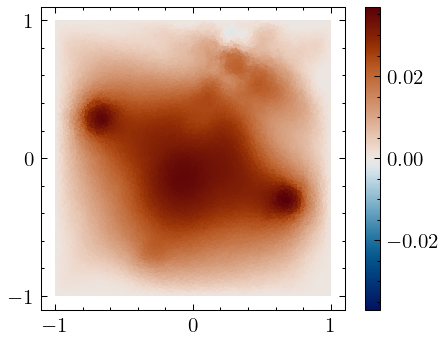

In [18]:
fig, ax = plt.subplots(dpi=150)
ax.set_yticks([-1, 0, 1])
ax.set_xticks([-1, 0, 1])
ax.set_aspect("equal")

diff = U2 - Uarr2
m = np.max(diff)

cmap_diff = Colormap("crameri:vik").to_mpl()

im = ax.tripcolor(triang, diff, cmap=cmap_diff, vmin=-m, vmax=m)
cbar = fig.colorbar(im, orientation='vertical')
plt.show()